# RAMP on predicting cyclist traffic in Paris

Authors: *Roman Yurchak (Symerio)*; also partially inspired by the air_passengers starting kit.


## Introduction

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

# Loading the data with pandas

First, download the data files,
 - [train.parquet](https://github.com/rth/bike_counters/releases/download/v0.1.0/train.parquet)
 - [test.parquet](https://github.com/rth/bike_counters/releases/download/v0.1.0/test.parquet)

and put them to into the data folder.


Data is stored in [Parquet format](https://parquet.apache.org/), an efficient columnar data format. We can load the train set with pandas,

In [2]:
data = pd.read_parquet('./data/train.parquet')

In [3]:
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585


We can check general information about different columns,

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455163 entries, 48321 to 928462
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 455163 non-null  category      
 1   counter_name               455163 non-null  category      
 2   site_id                    455163 non-null  int64         
 3   site_name                  455163 non-null  category      
 4   bike_count                 455163 non-null  float64       
 5   date                       455163 non-null  datetime64[ns]
 6   counter_installation_date  455163 non-null  datetime64[ns]
 7   counter_technical_id       455163 non-null  category      
 8   latitude                   455163 non-null  float64       
 9   longitude                  455163 non-null  float64       
 10  log_bike_count             455163 non-null  float64       
dtypes: category(4), datetime64[ns](2), float64(4), i

and in particular the number of unique entries in each column,

In [5]:
data.nunique(axis=0)

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    977
date                         8230
counter_installation_date      22
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                977
dtype: int64

We have a 30 counting sites where sometimes multiple counters are installed per location.  Let's look at the most frequented stations,

In [6]:
data.groupby(['site_name', 'counter_name'])['bike_count'].sum().sort_values(ascending=False).head(10).to_frame()

,,bike_count
site_name,counter_name,
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,1809231.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1406900.0
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1357868.0
67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1036575.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,914089.0
27 quai de la Tournelle,27 quai de la Tournelle SE-NO,888717.0
Quai d'Orsay,Quai d'Orsay E-O,849724.0
Totem Cours la Reine,Totem Cours la Reine O-E,806149.0
Face au 48 quai de la marne,Face au 48 quai de la marne SO-NE,806071.0


In [7]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, 'year'] = X['date'].dt.year
    X.loc[:, 'month'] = X['date'].dt.month
    X.loc[:, 'day'] = X['date'].dt.day
    X.loc[:, 'weekday'] = X['date'].dt.weekday
    X.loc[:, 'hour'] = X['date'].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"]) 

data

In [8]:
data

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585
...,...,...,...,...,...,...,...,...,...,...,...
928450,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,51.0,2021-08-08 18:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,3.951244
928453,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,1.0,2021-08-09 02:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,0.693147
928456,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,61.0,2021-08-09 08:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,4.127134
928459,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,44.0,2021-08-09 10:00:00,2020-11-29,Y2H20114504,48.839770,2.301980,3.806662


## Test vacances scolaires

In [9]:
data['date'].head()

48321   2020-09-01 02:00:00
48324   2020-09-01 03:00:00
48327   2020-09-01 04:00:00
48330   2020-09-01 15:00:00
48333   2020-09-01 18:00:00
Name: date, dtype: datetime64[ns]

In [10]:
#!pip install jours-feries-france
#import datetime
#from vacances_scolaires_france import SchoolHolidayDates
#d = SchoolHolidayDates()
#data['holiday?'] = d.is_holiday_for_zone(pd.to_datetime(data['date']).dt.date, 'C')

  Created wheel for jours-feries-france: filename=jours_feries_france-0.7.0-py3-none-any.whl size=4996 sha256=0e0e87c2dd66b402cd9fd1f6338be5495c4ae61bcfc1a90c5b2dfe56d717ab28
  Stored in directory: /Users/charlesproye/Library/Caches/pip/wheels/16/db/aa/b1bbf641103b26debe7ed5cc7e60c331137ec84e09986b0e7b
Successfully built jours-feries-france


ValueError: date should be a datetime.date

In [ ]:
#_encode_dates(data[['date']].head())

,year,month,day,weekday,hour
48321,2020,9,1,1,2
48324,2020,9,1,1,3
48327,2020,9,1,1,4
48330,2020,9,1,1,15
48333,2020,9,1,1,18


To use this function with scikit-learn estimators we wrap it with [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html),

In [ ]:
#from sklearn.preprocessing import FunctionTransformer

#date_encoder = FunctionTransformer(_encode_dates, validate=False)
#date_encoder.fit_transform(data[['date']]).head()

,year,month,day,weekday,hour
48321,2020,9,1,1,2
48324,2020,9,1,1,3
48327,2020,9,1,1,4
48330,2020,9,1,1,15
48333,2020,9,1,1,18


Since it is unlikely that, for instance, that `hour` is linearly correlated with the target variable, we would need to additionally encode categorical features for linear models. This is classically done with [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), though other encoding strategies exist.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)

enc.fit_transform(_encode_dates(data[['date']])[['hour']])


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Linear model

Let's now construct our first linear model with [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). We use a few helper functions defined in `problem.py` of the starting kit to load the public train and test data:

In [ ]:
import problem

X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

In [ ]:
X_train

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,counter_technical_id,latitude,longitude
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429
...,...,...,...,...,...,...,...,...,...
928450,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-08-08 18:00:00,2020-11-29,Y2H20114504,48.839770,2.301980
928453,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-08-09 02:00:00,2020-11-29,Y2H20114504,48.839770,2.301980
928456,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-08-09 08:00:00,2020-11-29,Y2H20114504,48.839770,2.301980
928459,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-08-09 10:00:00,2020-11-29,Y2H20114504,48.839770,2.301980


and

In [ ]:
y_train

array([0.        , 0.69314718, 0.        , ..., 4.12713439, 3.80666249,
       4.4308168 ])

Where `y` contains the `log_bike_count` variable. 

The test set is in the future as compared to the train set,

In [ ]:
print(f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}')
print(f'Train: n_samples={X_test.shape[0]},  {X_test["date"].min()} to {X_test["date"].max()}')

Train: n_samples=455163,  2020-09-01 01:00:00 to 2021-08-09 23:00:00
Train: n_samples=41608,  2021-08-10 01:00:00 to 2021-09-09 23:00:00


In [ ]:

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
# Pour les années
from sklearn.preprocessing import StandardScaler

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[['date']]).columns.tolist()[1:]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
year_encoder = StandardScaler()
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer([
    ('date', OneHotEncoder(handle_unknown="ignore"), date_cols),
    ('cat', categorical_encoder, categorical_cols),
    ('year', year_encoder, ['year'])
])

#preprocessor.fit_transform(X_train)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x7faffab420d0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day', 'weekday',
                                                   'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name']),
                                                 ('year', StandardScaler(),
                                                  ['year'])])),
                ('ridge', Ridge())])

We then evaluate this model with the RMSE metric,

In [ ]:
from sklearn.metrics import mean_squared_error

print(f'Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}')
print(f'Test set, RMSE={mean_squared_error(y_test, pipe.predict(X_test), squared=False):.2f}')

Train set, RMSE=0.80
Test set, RMSE=0.73


The model doesn't have enough capacity to generalize on the train set, since we have lots of data with relatively few parameters. However it happened to work somewhat better on the test set. We can compare these results with the baseline predicting the mean value,

In [ ]:
print('Baseline mean prediction.')
print(f'Train set, RMSE={mean_squared_error(y_train, np.full(y_train.shape, y_train.mean()), squared=False):.2f}')
print(f'Test set, RMSE={mean_squared_error(y_test, np.full(y_test.shape, y_test.mean()), squared=False):.2f}')

Baseline mean prediction.
Train set, RMSE=1.68
Test set, RMSE=1.44


which illustrates that we are performing better than the baseline.

Let's visualize the predictions for one of the stations,

In [ ]:
mask = ((X_test['counter_name'] == 'Totem 73 boulevard de Sébastopol S-N')
        & (X_test['date'] > pd.to_datetime('2021/09/01'))
        & (X_test['date'] < pd.to_datetime('2021/09/08')))

df_viz = X_test.loc[mask].copy()
df_viz['bike_count'] = np.exp(y_test[mask.values]) - 1
df_viz['bike_count (predicted)'] = np.exp(pipe.predict(X_test[mask])) -  1

Text(0, 0.5, 'bike_count')

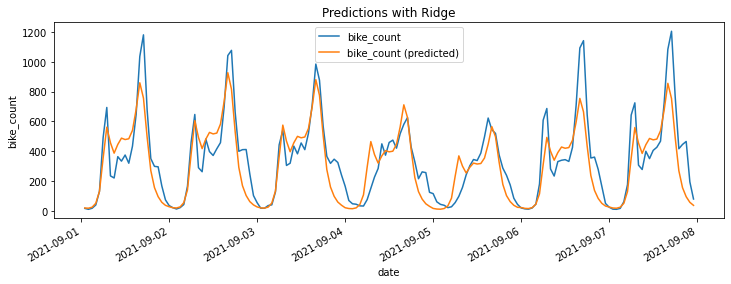

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

df_viz.plot(x='date', y='bike_count', ax=ax)
df_viz.plot(x='date', y='bike_count (predicted)', ax=ax)
ax.set_title('Predictions with Ridge')
ax.set_ylabel('bike_count')

So we start to see the daily trend, and some of the week day differences are accounted for, however we still miss the details and the spikes in the evening are under-estimated.

A useful way to visualize the error is to plot `y_pred` as a function of `y_true`,

<AxesSubplot:xlabel='y_true', ylabel='y_pred'>

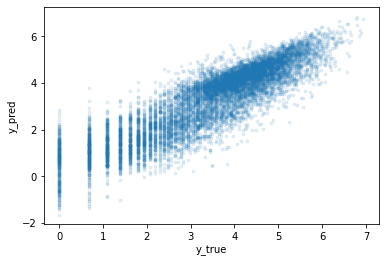

In [ ]:
fig, ax = plt.subplots()

df_viz = pd.DataFrame({'y_true': y_test, 'y_pred': pipe.predict(X_test)}).sample(10000, random_state=0)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)

It is recommended to use cross-validation for hyper-parameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or more reliable model evaluation with [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score). In this case, because we want the test data to always be in the future as compared to the train data, we can use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html),

<img src="https://i.stack.imgur.com/Q37Bn.png" />

The disadvantage, is that we can either have the training set size be different for each fold which is not ideal for hyper-parameter tuning (current figure), or have constant sized small training set which is also not ideal given the data periodicity. This explains that generally we will have worse cross-validation scores than test scores, 

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')
print('RMSE: ', scores)
print(f'RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}')

RMSE:  [-0.82872129 -1.01361234 -0.82012086 -1.08268358 -0.94019592 -1.4223016 ]
RMSE (all folds): 1.02 ± 0.204


## Tree based model

For tabular data tree based models often perform well, since they are able to learn non linear relationships between features, which would take effort to manually create for the linear model. Here will use Histogram-based Gradient Boosting Regression ([HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html)) which often will produce good results on arbitrary tabular data, and is fairly fast.

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[['date']]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer([
    ('date', "passthrough", date_cols),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
])

regressor = HistGradientBoostingRegressor(random_state=0)

pipe =  make_pipeline(date_encoder, preprocessor, regressor)
pipe['columntransformer']

ColumnTransformer(transformers=[('date', 'passthrough',
                                 ['year', 'month', 'day', 'weekday', 'hour']),
                                ('cat',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['counter_name', 'site_name'])])

## Random Forest Regressor - Test and tuning

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[['date']]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer([
    ('date', "passthrough", date_cols),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
])

In [ ]:
# Tune random forest parameters
def RFR_tuning_n_estimators(parameters):
    score_stock = np.zeros(parameters.shape)
    score_test = np.zeros(parameters.shape)
    for i, parameter in enumerate(parameters):
        regressor = RandomForestRegressor(random_state=0, n_estimators=parameter)
        print(regressor)
        pipe =  make_pipeline(date_encoder, preprocessor, regressor)
        pipe.fit(X_train, y_train)
        print(pipe)
        score_stock[i] = mean_squared_error(y_train, pipe.predict(X_train), squared=False)
        score_test[i] = mean_squared_error(y_test, pipe.predict(X_test), squared=False)
        print(score_stock)
        
    return score_stock, score_test

In [ ]:
# Plot them : Conclude, the more estimators the better
parameters = np.arange(20, 50, step=10)

#y, z = RFR_tuning_n_estimators(parameters)

#plt.plot(parameters, y, label='train');
#plt.plot(parameters, z, label='test');

In [ ]:
def RFR_tuning_min_sample_leaf(parameters):
    score_stock = np.zeros(parameters.shape)
    score_test = np.zeros(parameters.shape)
    for i, parameter in enumerate(parameters):
        regressor = RandomForestRegressor(random_state=0, min_samples_leaf=parameter)
        print(regressor)
        pipe =  make_pipeline(date_encoder, preprocessor, regressor)
        pipe.fit(X_train, y_train)
        print(pipe)
        score_stock[i] = mean_squared_error(y_train, pipe.predict(X_train), squared=False)
        score_test[i] = mean_squared_error(y_test, pipe.predict(X_test), squared=False)
        print(score_stock)
        
    return score_stock, score_test

In [ ]:
# Plot them : Conclude, the more estimators the better
#parameters = np.arange(1,3)

#y, z = RFR_tuning_min_sample_leaf(parameters)

#plt.plot(parameters, y, label='train');
#plt.plot(parameters, z, label='test');

### ----------------------------------------------------------------------------------------------------------------------------------

## Test 2 : LightGBM

In [ ]:
import lightgbm as lgb
X_train

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,counter_technical_id,latitude,longitude
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429
...,...,...,...,...,...,...,...,...,...
928450,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-08-08 18:00:00,2020-11-29,Y2H20114504,48.839770,2.301980
928453,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-08-09 02:00:00,2020-11-29,Y2H20114504,48.839770,2.301980
928456,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-08-09 08:00:00,2020-11-29,Y2H20114504,48.839770,2.301980
928459,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-08-09 10:00:00,2020-11-29,Y2H20114504,48.839770,2.301980


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor

date_encoder = FunctionTransformer(_encode_dates)
date_cols = ['month', 'day', 'weekday', 'hour']

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]
numeric_cols = ['year']

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ('numeric', StandardScaler(), numeric_cols)
        
    ]
)

    #'estimator__lgbmregressor__min_child_samples', 
    #'estimator__lgbmregressor__min_child_weight', 
    #'estimator__lgbmregressor__min_split_gain', 
    #'estimator__lgbmregressor__n_estimators', 
    #'estimator__lgbmregressor__n_jobs', 
    #'estimator__lgbmregressor__num_leaves', 
    #'estimator__lgbmregressor__objective', 
    #'estimator__lgbmregressor__random_state', 
    #'estimator__lgbmregressor__reg_alpha', 
    #'estimator__lgbmregressor__reg_lambda', 
    #'estimator__lgbmregressor__silent', 
    #'estimator__lgbmregressor__subsample', 
    #'estimator__lgbmregressor__subsample_for_bin', 
    #'estimator__lgbmregressor__subsample_freq', 
    #'estimator__lgbmregressor__boosting_type', 
    #'estimator__lgbmregressor__class_weight', 
    #'estimator__lgbmregressor__colsample_bytree', 
    #'estimator__lgbmregressor__importance_type', 

params = {}
params['lgbmregressor__learning_rate'] = [0.25]
params['lgbmregressor__boosting_type'] = ['gbdt']
params['lgbmregressor__objective'] = ['regression']
params['lgbmregressor__metric'] = ['rmse']
params['lgbmregressor__num_leaves'] = [300]
params['lgbmregressor__min_data'] = [4]
params['lgbmregressor__max_depth'] = [20]
params['lgbmregressor__n_estimators'] = [300]
params['lgbmregressor__task']= ['train']
params["lgbmregressor__max_bin"]= [512]
params['lgbmregressor__reg_alpha'] = 0
params['lgbmregressor__reg_lambda'] = 0


regressor = lgb.LGBMRegressor()
#regressor = HistGradientBoostingRegressor()

pipe = make_pipeline(date_encoder, preprocessor, regressor)

model_grid_search = GridSearchCV(pipe, param_grid=params, n_jobs=-1, cv=5)
result_train = model_grid_search.fit(X_train, y_train)
result_test = model_grid_search.fit(X_test, y_test)

/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/ensemble/_hist_gradient_boosting/gradient_boosting.py", line 202, in fit
    X, y = self._validate_data(X, y, dtype=[X_DTYPE],
  File "/Users/charlesproye/opt/miniconda3/envs/boost/lib/python3.8/site-packages/sklearn/base.py", line 433, in _val

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [ ]:

regressor = lgb.LGBMRegressor(boosting_type= 'gbdt', learning_rate= 0.25, max_bin= 512, max_depth= 20, metric= 'rmse', min_data= 4, n_estimators= 300, num_leaves= 200, objective= 'regression', task= 'train')
pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x7faffab420d0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day', 'weekday',
                                                   'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name']),
                                                 ('numeric', StandardScaler(),
                                                  ['year'])])),
                ('lgbmregressor',
                 LGBMRegressor(learning_rate=0.25, max_bin=512, max_depth=20,
            

In [ ]:
print(result_train.best_params_)
print(result_test.best_params_)


{'lgbmregressor__boosting_type': 'gbdt', 'lgbmregressor__learning_rate': 0.25, 'lgbmregressor__max_bin': 512, 'lgbmregressor__max_depth': 20, 'lgbmregressor__metric': 'rmse', 'lgbmregressor__min_data': 4, 'lgbmregressor__n_estimators': 300, 'lgbmregressor__num_leaves': 300, 'lgbmregressor__objective': 'regression', 'lgbmregressor__task': 'train'}
{'lgbmregressor__boosting_type': 'gbdt', 'lgbmregressor__learning_rate': 0.25, 'lgbmregressor__max_bin': 512, 'lgbmregressor__max_depth': 20, 'lgbmregressor__metric': 'rmse', 'lgbmregressor__min_data': 4, 'lgbmregressor__n_estimators': 300, 'lgbmregressor__num_leaves': 300, 'lgbmregressor__objective': 'regression', 'lgbmregressor__task': 'train'}


In [ ]:
scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error', error_score=np.nan)
print(f'RMSE: {-scores.mean():.3} ± {(-scores).std():.3}')

[LightGBM] [Warning] min_data_in_leaf is set with min_data=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set with min_data=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set with min_data=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set with min_data=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set with min_data=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
RMSE: 0.903 ± 0.22


In [ ]:
mask = ((X_test['counter_name'] == 'Totem 73 boulevard de Sébastopol S-N')
        & (X_test['date'] > pd.to_datetime('2021/09/01'))
        & (X_test['date'] < pd.to_datetime('2021/09/08')))

df_viz = X_test.loc[mask].copy()
df_viz['bike_count'] = np.exp(y_test[mask.values]) - 1
df_viz['bike_count (predicted)'] = np.exp(pipe.predict(X_test[mask])) -  1

Text(0, 0.5, 'bike_count')

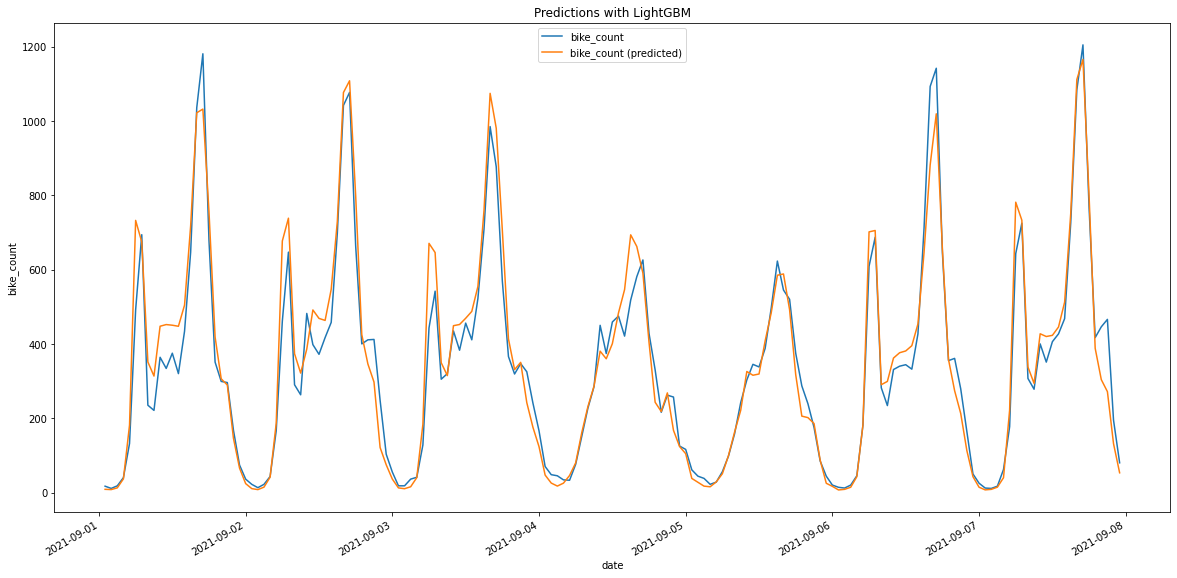

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

df_viz.plot(x='date', y='bike_count', ax=ax)
df_viz.plot(x='date', y='bike_count (predicted)', ax=ax)
ax.set_title('Predictions with LightGBM')
ax.set_ylabel('bike_count')

## Using external data

In this starting kit you are provided with weather data from Meteo France, which could correlate with cyclist traffic. It is not very accurate however, as the station is in Orly (15km from Paris) and only provides 3 hour updates.

To load the external data,

In [ ]:
df_ext = pd.read_csv(Path('submissions') / 'starting_kit' / 'external_data.csv')
df_ext.head()

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4
0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,272.15,96,...,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,270.95,98,...,1500.0,2.0,3.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN
2,7149,2021-01-01 06:00:00,100950,30,3,290,2.6,271.95,271.65,98,...,480.0,4.0,6.0,2000.0,6.0,3.0,3000.0,NaN,NaN,NaN
3,7149,2021-01-01 09:00:00,101100,150,2,280,1.7,272.45,272.05,97,...,1740.0,3.0,3.0,2800.0,NaN,NaN,NaN,NaN,NaN,NaN
4,7149,2021-01-01 12:00:00,101110,30,0,50,1.0,276.95,274.15,82,...,330.0,4.0,6.0,570.0,7.0,6.0,810.0,NaN,NaN,NaN


You can find the detailed documentation for each feature [in this PDF](https://donneespubliques.meteofrance.fr/client/document/doc_parametres_synop_168.pdf) (in French). Here the only feature we consider is the temperature. We will use [pandas.merge_asof](https://pandas.pydata.org/pandas-docs/dev/reference/api/pandas.merge_asof.html) to merge on date, using the closest available date (since the sampling between the external data and the counter data).

In [ ]:
# In this notebook we define the __file__ variable to be in the same conditions as when running the
# RAMP submission

__file__ = Path('submissions') /  'starting_kit' /  'estimator.py'


def _merge_external_data(X):
    file_path = Path(__file__).parent / 'external_data.csv'
    df_ext = pd.read_csv(file_path, parse_dates=['date'])
    print(df_ext)
    X = X.copy()
    # When using merge_asof left frame need to be sorted
    X['orig_index'] = np.arange(X.shape[0])
    X = pd.merge_asof(X.sort_values('date'), df_ext[['date', 't']].sort_values('date'), on='date')
    # Sort back to the original order
    X = X.sort_values('orig_index')
    del X['orig_index']
    return X
    

In [ ]:
X_train_merge = _merge_external_data(X_train)
X_train_merge

Similarly we can wrap this function into a FunctionTranformer to use it in a scikit-learn pipeline. Now let's see whether this additional feature improves the model,

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[['date']]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

numeric_cols = ['t']

preprocessor = ColumnTransformer([
    ('date', "passthrough", date_cols),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
    ('numeric', 'passthrough', numeric_cols)
])

regressor = HistGradientBoostingRegressor(random_state=0)

pipe =  make_pipeline(
    FunctionTransformer(_merge_external_data, validate=False),
    date_encoder,
    preprocessor,
    regressor
)

In [ ]:
scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error', error_score=np.nan)
print(f'RMSE: {-scores.mean():.3} ± {(-scores).std():.3}')

## Feature importance

We can check the feature importances using the function [sklearn.inspection.permutation_importances](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html). Since the first step of our pipeline adds the temperature and extract the date components, we want to apply this transformation those steps, to check the importance of all features. Indeed, we can perform sklearn.inspection.permutation_importances at any stage of the pipeline.

In [ ]:
merger = pipe[:2]
X_train_augmented = merger.transform(X_train)
X_test_augmented = merger.transform(X_test)

predictor = pipe[2:]
_ = predictor.fit(X_train_augmented, y_train)

In [ ]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(
    predictor, X_train_augmented[:20000], y_train[:20000], n_repeats=10, random_state=0
)

In [ ]:
sorted_idx = feature_importances.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(feature_importances.importances[sorted_idx].T,
           vert=False, labels=X_train_augmented.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

## Submission

To submit your code, you can refer to the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html).

Next steps could be,
 - more in depth exploratory analysis
 - use more external data (you can add your data to `external_data.csv` but it needs to remain a single file)
 - more advanced feature extraction and modeling (see for [this scikit-learn tutorial](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py))
 - hyper-parameter search with GridSearchCV
 